# Deployment - Proof of Concept

In [1]:
import torch

````{margin}
```{note}
Getrennter Import von *torch*, weil sonst der Kernel in Lokaler Umgebung abstürzt.
```
````

In [2]:
import os
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode() # To show plotly plots when notebook is exported to html

## Anwendung auf Screenshots

Das beste Modell wird zur Auswertung von anderen Satellitenbildern verwendet. Dies kann über das Terminal mit `detect.py` oder mit PyTorch erfolgen.

Beim Deployment kann nicht mit einzelnen 640px-Tiles gearbeitet werden, weil geteiltes Fluggerät - im Fall einer Detektion - mehrfach gezählt wird. Jedoch lassen die Erfahrungen aus der Modelloptimierungen und dem Tarnkappenbomber-Beispiel darauf schließen, dass für die Screenshots mit hoher Zoomstufe bessere Detektion möglich ist.

Zur Veranschaulichung werden zunächst Bilder von der Marine Corps Air Station (MACS) in Iwakuni, Japan vorgestellt und die erwartbaren Ergebnisse mit den Detektionen verglichen. Dabei wurden mehrere Screenshots mit den Skalen 20m, 50m und 100m erstellt. Bei der 20m-Skala wurden nur wenige Punkte aus der 100m-Skala "fotografiert". Der folgende Plot zeigt drei examplarische Bilder nach Skala. Der Helikopter in der rechten oberen Ecke wird erst bei zunehmenden Zoom besser sichtbar. Dies gilt auch für die Helikopter beim Punkt (100,700), welche in der vierten Abbildung zusehen sind.

In [3]:
scales = ['100m','50m','20m']
for i in range(3):
    scale = scales.pop(-1)
    myPath = 'nb_images/deployment/' + scale
    print(f"Für Skala %s liegen %d Screenshots vor."%(scale,len(os.listdir(myPath))))

Für Skala 20m liegen 3 Screenshots vor.
Für Skala 50m liegen 6 Screenshots vor.
Für Skala 100m liegen 2 Screenshots vor.


````{margin}
```{note}
cv2.imread innerhalb der cvtColor-Methode, weil cv2 mit dem Farbmodus BGR anstelle von RGB arbeitet.
```
````

In [23]:
img1 = cv2.cvtColor(cv2.imread('nb_images/deployment/100m/MCAS_Iwakuni_1_100m.png'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('nb_images/deployment/50m/MCAS_Iwakuni_2_50m.png'),cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('nb_images/deployment/20m/MCAS_Iwakuni_1_20m.png'),cv2.COLOR_BGR2RGB)

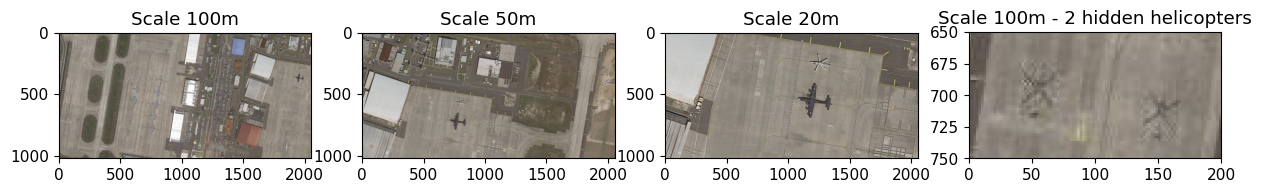

In [24]:
scales = ['100m','50m','20m']
fig, axes = plt.subplots(1,4,figsize=(15,7))
for i in range(3):
    axes[i].set_title('Scale '+scales.pop(0))
axes[0].imshow(img1)
axes[1].imshow(img2)
axes[2].imshow(img3)
axes[3].set_ylim(750,650)
axes[3].set_xlim(0,200)
axes[3].set_title('Scale 100m - 2 hidden helicopters')
axes[3].imshow(img1)

<table style='font-size:10px'>
<tr>
<th><p align='left'>Scale 100m</p></th>
<th><p align='left'>Scale 20m und 50m</p></th>
</tr>
<tr>
<td>
  
```text
Kartendaten Copyright 2022: Google
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, Planet.com
```
  
</td>
<td>

```text
Kartendaten Copyright 2022: Google
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies
```

</td>
</tr>
</table>





```{glue:figure} boot_fig_depl1
:name: "depl_sat"

Satellitenbilder ohne Detektionen
```

In [25]:
store_backend = plt.get_backend()
print(f"Das matplotlib Backend lautet: {store_backend}")

Das matplotlib Backend lautet: module://matplotlib_inline.backend_inline


Über torch.hub.load wird der aktuellst Release im YOLOv5-Repository abgerufen. Der Parameter custom und path verweisen auf die `best.pt` von Modell 13. Das Modell wird mit den Standard-Detektion-Parametern auf die drei Screenshots angewendet. Dabei werden die Image Size 1280 und augment=True verwendet.

* Augment wurde beim Tarnkappenbomber erläutert
* Große Image Size wegen großen Input-Bildern

Mit `results.show()` öffnet sich ein separates Fenster, welches nicht in den Output von Jupyter Notebook eingebunden werden konnte. Daher wird der Output gespeichert und geplotet. Ferner wird ein Pandas Dataframe erzeugt um die Anzahl an Flugzeugen und Helikoptern in nummerischer Form zu erhalten.

````{margin}
```{note}
YOLOv5 setzt das Backend von matplotlib auf 'agg' (non GUI), weshalb dieses zunächst ausgelesen und nach der Detektion wieder eingelesen wird.
```
````

In [26]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/Users/markus/NoCloudDoks/Offline_Repos/best.pt', _verbose=False)
#model.amp = True
#model.conf = 0.25
#model.iou = 0.45
results = model([img1,img2,img3], size=1280, augment=True)

Using cache found in /Users/markus/.cache/torch/hub/ultralytics_yolov5_master


In [27]:
def set_matplotlib_backend():
    print(f"Das Backend nach der Modellanwendung lautete {plt.get_backend()}")
    plt.switch_backend(store_backend)
    print(f"und wurde auf {plt.get_backend()} zurückgesetzt.")

set_matplotlib_backend()

Das Backend nach der Modellanwendung lautete module://matplotlib_inline.backend_inline
und wurde auf module://matplotlib_inline.backend_inline zurückgesetzt.


In [28]:
#results.show()
results.save()
results.print()

Saved 3 images to runs/detect/exp2
image 1/3: 1018x2056 12 planes, 1 helicopter
image 2/3: 1018x2056 1 plane, 1 helicopter
image 3/3: 1018x2056 1 plane, 1 helicopter
Speed: 20.3ms pre-process, 11666.7ms inference, 1.3ms NMS per image at shape (3, 3, 640, 1280)


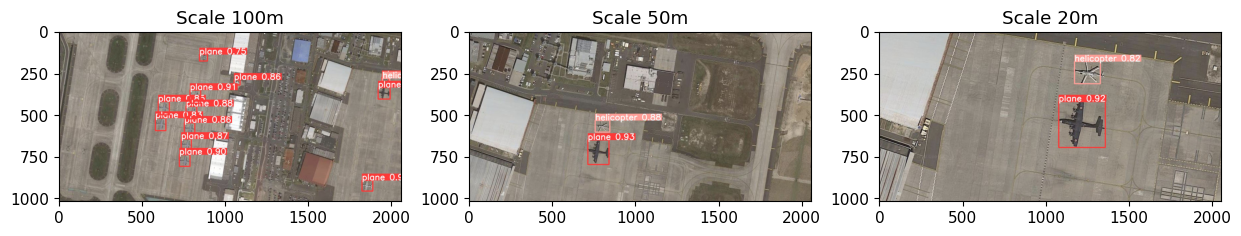

In [30]:
scales = ['100m','50m','20m']
output = list()
sorted_images = os.listdir('runs/detect/exp')
sorted_images.sort(key=lambda f: int(re.sub('\D', '', f)))
fig, axes = plt.subplots(1,3,figsize=(15,7))
for i in range(len(sorted_images)):
    img = sorted_images.pop(0)
    axes[i].set_title('Scale '+scales.pop(0))
    axes[i].imshow(cv2.cvtColor(cv2.imread('runs/detect/exp/'+img),cv2.COLOR_BGR2RGB))


<table style='font-size:10px'>
<tr>
<th><p align='left'>Scale 100m</p></th>
<th><p align='left'>Scale 20m und 50m</p></th>
</tr>
<tr>
<td>
  
```text
Kartendaten Copyright 2022: Google
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, Planet.com
```
  
</td>
<td>

```text
Kartendaten Copyright 2022: Google
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies
```

</td>
</tr>
</table>





```{glue:figure} boot_fig_depl2
:name: "depl_sat_dect"

Deployment Satellitenbild mit Detektionen
```

An dieser Stelle wird der obere Plot erläutert. Bei den Skalen 50m und 20m wurden alle Helikopter und Flugzeuge erkannt. Für die Skala 100m wurden ebenfalls alle 11 Flugzeuge erkannt, sowie einer von drei Helikoptern. 

Nachfolgend werden die Resultate in einen Dataframe geladen. Dieser enthält die Koordinaten für die Bounding Boxes, den Konfidenzwert, die Klasse (codiertes Label) und die Labelbezeichnung je Erkennung. Ferner wird eine Spalte mit dem Location-Name manuell ergänzt.  
Die Auswertung des Dataframes zeigt, dass der Helikopter in der rechten oberen Ecke auch als Flugzeug erkannt wurde. Für die nahezu gleichen Koordinaten wurden zwei Detektionen ausgegeben: 1x Flugzeug und 1x Helikopter. Der Helikopter wurde mit Konfidenz von 49.6% als Flugzeug und mit einer Konfidenz von 78.8% als Helikopter erkannt. Durch einen höheren Konfidenz-Threshold hätte die doppelte Detektion vermieden werden können.

Es kann festgehalten werden, dass Erkennungen auf einer anderen Image-Size als beim Training angewendet werden können. Dies führt dennoch zu validen Ergebnissen.

In [31]:
# Über Index lassen sich die Results zu den anderen Bildern ausgeben.
df1 = results.pandas().xyxy[0]
df1['location'] = 'MACS Iwakuni'
df1.head()

xmin        ymin         xmax        ymax  confidence  class   name  \
0  1821.678711  894.825073  1886.273804  958.315918    0.918029      0  plane   
1   787.788574  353.015533   851.709961  432.887817    0.911824      0  plane   
2   723.662231  740.823608   787.627930  810.868469    0.897158      0  plane   
3  1918.737427  338.720581  1990.789307  407.965149    0.892235      0  plane   
4   763.401428  451.479797   828.048645  525.504272    0.877468      0  plane   

       location  
0  MACS Iwakuni  
1  MACS Iwakuni  
2  MACS Iwakuni  
3  MACS Iwakuni  
4  MACS Iwakuni

In [32]:
df1

xmin        ymin         xmax        ymax  confidence  class  \
0   1821.678711  894.825073  1886.273804  958.315918    0.918029      0   
1    787.788574  353.015533   851.709961  432.887817    0.911824      0   
2    723.662231  740.823608   787.627930  810.868469    0.897158      0   
3   1918.737427  338.720581  1990.789307  407.965149    0.892235      0   
4    763.401428  451.479797   828.048645  525.504272    0.877468      0   
5    734.369202  646.952820   795.341003  716.283630    0.865268      0   
6   1052.330200  292.795135  1088.553223  323.579651    0.858080      0   
7    753.712769  549.680603   816.122925  618.663879    0.856187      0   
8    596.764038  422.147583   663.359619  501.464813    0.854075      0   
9    579.444885  521.142822   642.616272  596.662109    0.826409      0   
10  1944.875244  283.715790  1988.547974  314.492401    0.788317      1   
11   844.597046  140.876587   892.565125  179.345428    0.747513      0   
12  1941.330688  277.971222  1982.947266  315.085510    0.496181      0   

          name      location  
0        plane  MACS Iwakuni  
1        plane  MACS Iwakuni  
2        plane  MACS Iwakuni  
3        plane  MACS Iwakuni  
4        plane  MACS Iwakuni  
5        plane  MACS Iwakuni  
6        plane  MACS Iwakuni  
7        plane  MACS Iwakuni  
8        plane  MACS Iwakuni  
9        plane  MACS Iwakuni  
10  helicopter  MACS Iwakuni  
11       plane  MACS Iwakuni  
12       plane  MACS Iwakuni

In [33]:
fig = px.box(df1,x='confidence')
fig.show()

```{glue:figure} boot_fig_depl3
:name: "depl_box"

Boxplot für die Konfidenz zur Detektion auf 100m
```


In [34]:
df1.iloc[[11,12]]

xmin        ymin         xmax        ymax  confidence  class  \
11   844.597046  140.876587   892.565125  179.345428    0.747513      0   
12  1941.330688  277.971222  1982.947266  315.085510    0.496181      0   

     name      location  
11  plane  MACS Iwakuni  
12  plane  MACS Iwakuni

## Proof of Concept - Use Case

Für den Proof-Of-Concept werden weitere Detektionen auf andere Satellitenbilder angewendet und die einzelnen Dataframes vertikal verknüpft. Dies ermöglicht die Realisierung des für den Use Case angestrebten Barplots, welcher den detektierten Bestand an Fluggerät je Standort darstellt.

Die folgenden Dataframes werden leer ausgegeben. D.h. Es wird kein Fluggerät erkannt. Es ist zu beachten, dass die Bilder deutlich größer sind als das oben präsentierte Beispiel.

````{margin}
```{note}
Im nachstehenden Kapitel wird die Herkunft der anderen Satellitenbilder erläutert.
```
````

In [35]:
img4 = cv2.cvtColor(cv2.imread('nb_images/deployment/RUS_Severomorsk.jpg'),cv2.COLOR_BGR2RGB)
results2 = model(img4)
df2 = results2.pandas().xyxy[0]
df2['location'] = 'Russia Severomorsk'
df2.head()

Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name, location]
Index: []

In [36]:
img5 = cv2.cvtColor(cv2.imread('nb_images/deployment/DEU_Ansbach_Katterbach.jpg'),cv2.COLOR_BGR2RGB)
results3 = model(img5)
df3 = results3.pandas().xyxy[0]
df3['location'] = 'DE Ansbach Katterbach'
df3.head()

Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name, location]
Index: []

In [37]:
df = pd.concat([df1,df2,df3])
df.tail()

xmin        ymin         xmax        ymax  confidence class  \
8    596.764038  422.147583   663.359619  501.464813    0.854075     0   
9    579.444885  521.142822   642.616272  596.662109    0.826409     0   
10  1944.875244  283.715790  1988.547974  314.492401    0.788317     1   
11   844.597046  140.876587   892.565125  179.345428    0.747513     0   
12  1941.330688  277.971222  1982.947266  315.085510    0.496181     0   

          name      location  
8        plane  MACS Iwakuni  
9        plane  MACS Iwakuni  
10  helicopter  MACS Iwakuni  
11       plane  MACS Iwakuni  
12       plane  MACS Iwakuni

In [38]:
fig = px.bar(
    df.groupby(['location','name']).count().reset_index(),
    x='location',
    y='class',
    color='name',
    barmode='group'
    )
fig.update_layout(
    xaxis_title="Standorte",
    yaxis_title="Anzahl",
    legend_title="Kategorie",
    title='Anzahl an Fluggerät nach Standort und Kategorie'
)
newnames = {'plane':'Flugzeuge', 'helicopter': 'Helikopter'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                    )
fig.show()

```{glue:figure} boot_fig_depl4
:name: "barplot_poc"

Barplot: Anzahl Fluggerät im Proof of Concept
```

## Beschaffung von Satellitenbilder

Die Satellitenbilder für das Deployment wurden mit dem [Map Tiles Downloader](https://github.com/AliFlux/MapTilesDownloader) von {cite:t}`MapTilesDown` heruntergeladen. Dadurch konnten kleinere Tiles eines Gebietes abgerufen und zusammengeführt werden.

Der Map Tile Downloader liefert keine genauen Angaben zum Copyright des Materials, weshalb diese Bilder nicht abgebildet werden. 

Der nachfolgende Code wurde verwendet um die einzelnen Tiles in ein großes Gesamtbild umzuwandeln. Dadurch sollen beispielsweise abgeschnittene Flügel oder andere Teile von Fluggerät wieder zusammengefügt werden. Dies führt jedoch wieder zu Problemen mit sehr großen Bildern. Tiling wäre also zu bevorzugen. Eine Möglichkeit zur Umsetzung wird im nachfolgenden Kapitel Deployment - Small Object Detection vorgestellt.

In [ ]:
'''
Bei den get_list_ functions wurde startswith verwendet
um versteckte Systemdateien zu ignorieren.
'''

def get_list_airbase(path,myString):
    return [file for file in os.listdir(path) if file.startswith(myString)]
    
def get_list_airbase_images(path):
    return [file for file in os.listdir(path) if file.startswith('1')]
    
def get_list_files(path):
    return [file for file in os.listdir(path) if not file.startswith('.')]
    
def concat_horizontal(path):
    myList = []
    images = get_list_files(path)
    images.sort()
    for img_dir in images:
        myList.append(concat_vertical(path+'/'+img_dir))
    return cv2.hconcat(myList)

def concat_vertical(path):
    myList = []
    images = get_list_files(path)
    images.sort()
    for img in images:
        myList.append(cv2.imread(path+'/'+img))
    return cv2.vconcat(myList)
    
def generate_images(path,myString):
    for i in get_list_airbase(path,myString):
        for j in get_list_airbase_images(path + i):
            name_string = i + '.jpg'
            cv2.imwrite(name_string,concat_horizontal(path + i + '/' + j))
    print ('Images for',myString,'generated.')

path = '/Users/markus/Dropbox/Object_Detection_Stuff/'
nations = ['USA_','DEU_','RUS_']
for n in nations: generate_images(path,n)